In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict 
import seaborn as sns

In [2]:
## Datasets
data_domains=pd.read_excel(r'C:\Users\linigodelacruz\Documents\PhD_2018\Documentation\Calculations\machine-learning-for-yeast\datasets-for-learning\proteins-domains-from-Pfam.xlsx',header=0,index_col='Unnamed: 0')
data_domains=data_domains.dropna()
data_sl=pd.read_excel(r'C:\Users\linigodelacruz\Documents\PhD_2018\Documentation\Calculations\machine-learning-for-yeast\datasets-for-learning\data-synthetic-lethals.xlsx',header=0)
data_nonsl=pd.read_excel(r'C:\Users\linigodelacruz\Documents\PhD_2018\Documentation\Calculations\machine-learning-for-yeast\datasets-for-learning\data-phenotypic-enhancement.xlsx',header=0)



## Building the feature matrix
 One matrix for true SL where each column is one pair of SL. Every column will be a vector of  0,1 or 2 depending on the comparison with the domain list. for colum i the jth element = 0 if the jth element of the domain list is not in neither protein A and B, 1, if it is in one of them and 2 if it is in both of them .  




## Building the list of proteins domains id per protein pair separately :

1. List of protein A: Search for the Sl/nSL database the query gene name and look in the protein domain database which protein domains id has each of those queries.
2. List of protein B: Search for the Sl/nSL database the target gene name of the previous query and look in the protein domain database which protein domains id has each of those target genes.

In [3]:

# Selecting the meaningful columns in the respective dataset
domain_id_list=data_domains['domain-name']
query_gene=data_sl['gene-query-name']
target_gene=data_sl['gene-target-name']
query_gene_nonlethal=data_nonsl['gene-query-name']
target_gene_nonlethal=data_nonsl['gene-target-name']

# Initialising the arrays
protein_a_list=[]
protein_b_list=[]
protein_a_list_non=[]
protein_b_list_non=[]

# For loop for 500 pairs from the SL/nSl pair list , and creating a big array of proteind domains id per protein pair
for m in np.arange(0,5000):
    protein_a=data_domains[data_domains['name']==query_gene[m]]
    protein_b=data_domains[data_domains['name']==target_gene[m]]
    protein_a_list.append(protein_a['domain-name'].tolist())
    protein_b_list.append(protein_b['domain-name'].tolist())

    protein_a_non=data_domains[data_domains['name']==query_gene_nonlethal[m]]
    protein_b_non=data_domains[data_domains['name']==target_gene_nonlethal[m]]
    protein_a_list_non.append(protein_a_non['domain-name'].tolist())
    protein_b_list_non.append(protein_b_non['domain-name'].tolist())
    

## Select from each ordered indexes of  domain id list which of them appear once, in both or in any of the domains of each protein pair

In [4]:
get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y] # a function that give the index of whether a value appear in array or not
a=[1,2,3,4,5,6,7,8,9,10]
get_indexes(20,a)

[]

In [10]:
x = np.unique(domain_id_list)
protein_feat_true=np.zeros(shape=(len(x),len(protein_a_list)))

for i in np.arange(0,len(protein_a_list)):
    index_a=[]
    pair=[protein_a_list[i],protein_b_list[i]]
    pair_a_b=np.concatenate(pair).ravel()
    for j in pair_a_b:
        index_a.append(get_indexes(j,x))

    array,index,counts=np.unique(index_a,return_index=True,return_counts=True)
    for k,m in zip(counts,index):
        if k ==2:
            protein_feat_true[index_a[m],i]=2
            
        if k==1:
            protein_feat_true[index_a[m],i]=1
            # print(index_a[m],i)



    



In [11]:
protein_feat_true_pd=pd.DataFrame(protein_feat_true.T)


# stats_lethals=protein_feat_true_pd.describe()
# stats_lethals.index

## Build a feature matrix using the rows per protein pair:

- Feature 1: Mean of the each row per protein par (a long vector of 0, 1 and 2)
- feature 2: Number of 0 
- feature 3: Number of 1
- feature 4: Number of 2

In [13]:
np.where(array==2)[0][0]

1

In [12]:
feature_post_true=defaultdict(dict)

for ind in protein_feat_true_pd.index:
    feature_post_true[ind]['Mean']=np.mean(protein_feat_true_pd.iloc[ind,:])
    feature_post_true[ind]['std']=np.std(protein_feat_true_pd.iloc[ind,:])
    array,index,counts=np.unique(protein_feat_true_pd.iloc[ind,:],return_index=True,return_counts=True)
    # feature_post_true[ind]['array']=array
    for i in array:
        if i == 0:
            feature_post_true[ind]['Nr of zeros']=counts[np.where(array==0)[0][0]]
        if i==1:
            feature_post_true[ind]['Nr of ones']=counts[np.where(array==1)[0][0]]
        if i==2:
            feature_post_true[ind]['Nr of twos']=counts[np.where(array==2)[0][0]]
    

In [13]:
feature_post_true_pd=pd.DataFrame(feature_post_true)



In [14]:
feature_post_true_pd=feature_post_true_pd.T

feature_post_true_pd=feature_post_true_pd.fillna(0)

In [15]:
feature_post_true_pd['lethality']=np.ones(shape=(len(protein_a_list)))

In [16]:
########################## Building the feature matrix for non-lethals pairs#################################

x = np.unique(domain_id_list)
protein_feat_nonlethal=np.zeros(shape=(len(x),len(protein_a_list_non)))

for i in np.arange(0,len(protein_a_list_non)):
    index_a=[]
    pair=[protein_a_list_non[i],protein_b_list_non[i]]
    pair_a_b=np.concatenate(pair).ravel()
    for j in pair_a_b:
        index_a.append(get_indexes(j,x))   
    array,index,counts=np.unique(index_a,return_index=True,return_counts=True)
    for k,m in zip(counts,index):
        if k >=2:
            protein_feat_nonlethal[index_a[m],i]=2
        if k==1:
            protein_feat_nonlethal[index_a[m],i]=1



In [17]:
protein_feat_nonlethal_pd=pd.DataFrame(protein_feat_nonlethal.T)


In [18]:
feature_post_false=defaultdict(dict)

for ind in protein_feat_nonlethal_pd.index:
    feature_post_false[ind]['Mean']=np.mean(protein_feat_nonlethal_pd.iloc[ind,:])
    feature_post_false[ind]['std']=np.std(protein_feat_nonlethal_pd.iloc[ind,:])
    array,index,counts=np.unique(protein_feat_nonlethal_pd.iloc[ind,:],return_index=True,return_counts=True)
    for i in array:
        if i == 0:
            feature_post_false[ind]['Nr of zeros']=counts[np.where(array==0)[0][0]]
        if i==1:
            feature_post_false[ind]['Nr of ones']=counts[np.where(array==1)[0][0]]
        if i==2:
            feature_post_false[ind]['Nr of twos']=counts[np.where(array==2)[0][0]]

In [19]:
feature_post_false_pd=pd.DataFrame(feature_post_false)



In [20]:
feature_post_false_pd=feature_post_false_pd.fillna(0)
feature_post_false_pd=feature_post_false_pd.T

feature_post_false_pd['lethality']=np.zeros(shape=(len(protein_a_list)))



In [21]:
feature_post=pd.concat([feature_post_true_pd,feature_post_false_pd],axis=0)

In [22]:
feature_post=feature_post.set_index(np.arange(0,2*len(protein_a_list)))

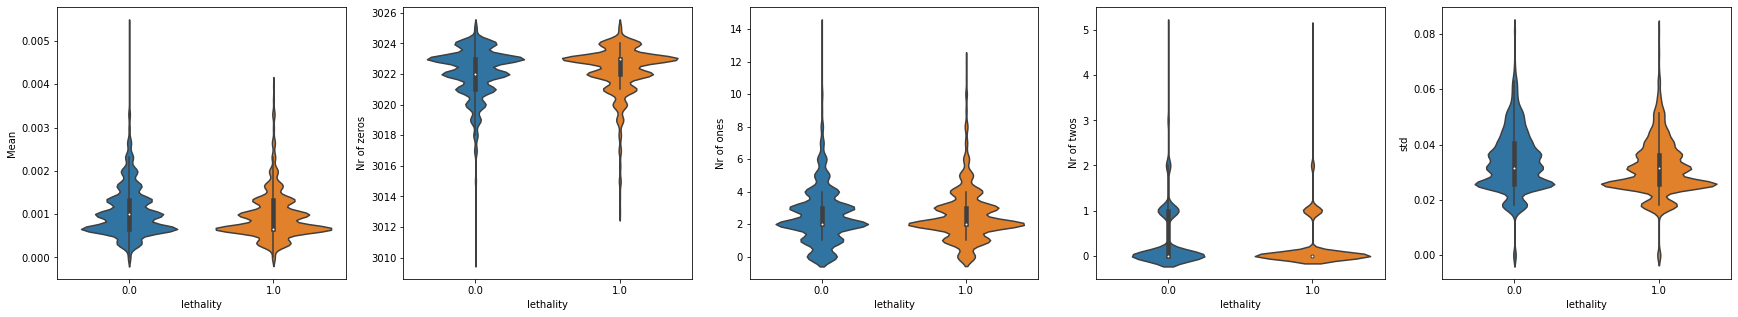

In [23]:
fig, axs = plt.subplots(ncols=5, figsize=(30,5))
sns.violinplot(x="lethality", y="Mean", data=feature_post,ax=axs[0])
sns.violinplot(x="lethality", y="Nr of zeros", data=feature_post,ax=axs[1])
sns.violinplot(x="lethality", y="Nr of ones", data=feature_post,ax=axs[2])
sns.violinplot(x="lethality", y="Nr of twos", data=feature_post,ax=axs[3])
sns.violinplot(x="lethality", y="std", data=feature_post,ax=axs[4])
# sns.pointplot(x="sibsp", y="survived", hue="sex", data=data, ax=axs[1])
# sns.pointplot(x="parch", y="survived", hue="sex", data=data, ax=axs[2])
# sns.pointplot(x="pclass", y="survived", hue="sex", data=data, ax=axs[3])
# sns.violinplot(x="survived", y="fare", hue="sex", data=data, ax=axs[4])

In [24]:
feature_post.corr().abs()[["lethality"]]

,lethality
Mean,0.091082
std,0.129263
Nr of zeros,0.049125
Nr of ones,0.000243
Nr of twos,0.133449
lethality,1.000000


In [25]:
feature_post.corr().abs()[["Nr of twos"]]

,Nr of twos
Mean,0.383026
std,0.689769
Nr of zeros,0.044215
Nr of ones,0.310059
Nr of twos,1.000000
lethality,0.133449


In [ ]:
# data_all.to_excel('feature-matrix-all.xlsx')

In [ ]:
############## Read the data ############################

# data_all=pd.read_excel('feature-matrix-all.xlsx')

In [ ]:
X, y = feature_post.drop(columns=["lethality"]), feature_post["lethality"]


In [33]:
X, y = feature_post.drop(columns=["lethality","std","Mean"]), feature_post["lethality"]
X.columns

Index(['Nr of zeros', 'Nr of ones', 'Nr of twos'], dtype='object')

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =  train_test_split(X,y,test_size = 0.3, random_state= 0)

In [28]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train_sc = sc_X.fit_transform(X_train)
X_test_sc = sc_X.transform(X_test)

In [29]:
from sklearn.decomposition import PCA
pca = PCA() 
X_train_pca = pca.fit_transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)
total=sum(pca.explained_variance_)
k=0
current_variance=0
while current_variance/total < 0.90:
    current_variance += pca.explained_variance_[k]
    k=k+1
print(k)

2


## how to check the importance of the features and how to plot a biplot. From [this question in stackoverflow](https://stackoverflow.com/questions/50796024/feature-variable-importance-after-a-pca-analysis)

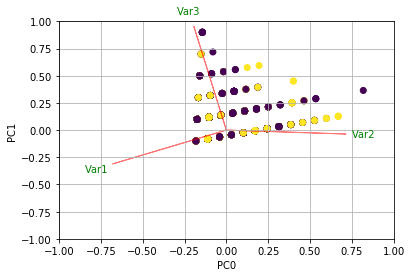

In [30]:
def myplot(score,coeff,labels=None,c=y_train):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = c)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(0))
plt.ylabel("PC{}".format(1))
plt.grid()

#Call the function. Use only the 2 PCs.
#pca = PCA()
myplot(X_train_pca[:,0:3],np.transpose(pca.components_[0:3, :]))
plt.show()

**Now, the importance of each feature is reflected by the magnitude of the corresponding values in the eigenvectors (higher magnitude - higher importance)**

In [31]:
pca.explained_variance_ratio_


array([6.58022503e-01, 3.41977497e-01, 2.25770894e-29])

**PC0 explains ```array[0]``` and PC1 ```array[1]```. Together, if we keep PC0 and PC1 only, they explain ```array[0]+array[1]``` 0f the data.**

In [32]:
print(abs( pca.components_ ))

[[0.67580333 0.71126353 0.19337543]
 [0.30973457 0.03597185 0.95014237]
 [0.66884554 0.70200443 0.2446128 ]]


**Here, pca.components_ has shape  ```[n_components, n_features]```. Thus, by looking at the PC1 (First Principal Component) which is the first row: ```[0.70310907 0.01421324 0.71093996]```, we conclude that feature 1 and feature 3 are the most important **

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
parameters = [{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
              {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]
search = GridSearchCV(SVC(), parameters, n_jobs=-1, verbose=1)
search.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  2.2min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']}, {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [35]:
best_parameters = search.best_estimator_
print(best_parameters)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [36]:
model=SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
model.fit(X_train, y_train)


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [37]:
y_pred=model.predict(X_test)

len(y_pred[y_pred==y_test]),len(y_pred)



(1706, 3000)

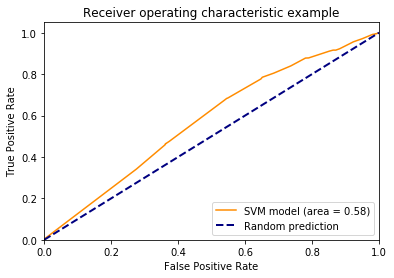

In [38]:
import sklearn.metrics as metrics
scores=model.fit(X_train, y_train).decision_function(X_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, scores)
area=metrics.auc(fpr,tpr)
plt.plot(fpr,tpr,color='darkorange',label='SVM model (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',label='Random prediction')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()



In [39]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics
print('Accuracy Score:',round(accuracy_score(y_test, y_pred),2))
#confusion matrix
cm = confusion_matrix(y_test, y_pred)

Accuracy Score: 0.57


Text(0.5, 257.44, 'Predicted label')

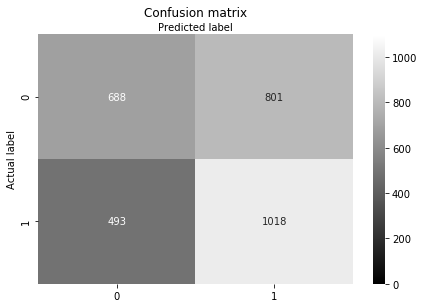

In [41]:
class_names=[1,2,3]
fig, ax = plt.subplots()
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
cm = confusion_matrix(y_test, y_pred)
class_names=['SL', 'nSL']

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(cm), annot=True, cmap="gray" ,fmt='g',vmin=0,vmax=1100)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


Precision ($P$) is defined as the number of true positives ($T_p$) over the number of true positives plus the number of false positives($F_p$).

$P=\frac{T_p}{T_p+F_p}$

Recall ($R$) is defined as the number of true positives ($T_p$) over the number of true positives plus the number of false negatives($F_n$).

$R=\frac{T_p}{T_p+F_n}$



In [42]:
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

Precision: 0.559648158328752
Recall: 0.6737260092653872


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.55')

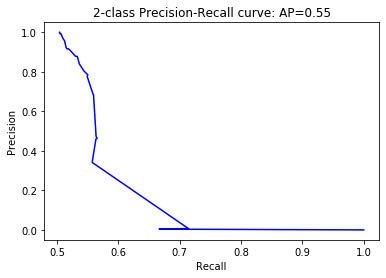

In [43]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test, scores)
average_precision = metrics.average_precision_score(y_test, scores)
plt.plot(precision,recall,color='blue')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

## Feature importance

First of all, I assume that you call features the variables and not the samples/observations. In this case, you could do something like the following by creating a biplot function that shows everything in one plot. In this example I am using the iris data.

Before the example, please note that the basic idea when using PCA as a tool for feature selection is to select variables according to the magnitude (from largest to smallest in absolute values) of their coefficients (loadings). See my last paragraph after the plot for more details.

PART1: I explain how to check the importance of the features and how to plot a biplot.

PART2: I explain how to check the importance of the features and how to save them into a pandas dataframe using the feature names.





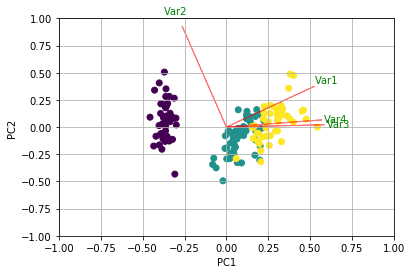

In [141]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler

iris = datasets.load_iris()
X = iris.data
y = iris.target
#In general a good idea is to scale the data
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)    

pca = PCA()
x_new = pca.fit_transform(X)

def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. Use only the 2 PCs.
myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()


Now, the importance of each feature is reflected by the magnitude of the corresponding values in the eigenvectors (higher magnitude - higher importance)

Let's see first what amount of variance does each PC explain.

pca.explained_variance_ratio_
[0.72770452, 0.23030523, 0.03683832, 0.00515193]
PC1 explains 72% and PC2 23%. Together, if we keep PC1 and PC2 only, they explain 95%.

Now, let's find the most important features.

print(abs( pca.components_ ))

[[0.52237162 0.26335492 0.58125401 0.56561105]
 [0.37231836 0.92555649 0.02109478 0.06541577]
 [0.72101681 0.24203288 0.14089226 0.6338014 ]
 [0.26199559 0.12413481 0.80115427 0.52354627]]
 
Here, pca.components_ has shape [n_components, n_features]. Thus, by looking at the PC1 (First Principal Component) which is the first row: [0.52237162 0.26335492 0.58125401 0.56561105]] we can conclude that feature 1, 3 and 4 (or Var 1, 3 and 4 in the biplot) are the most important.

To sum up, look at the absolute values of the Eigenvectors' components corresponding to the k largest Eigenvalues. In sklearn the components are sorted by explained_variance_. The larger they are these absolute values, the more a specific feature contributes to that principal component.

In [44]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
np.random.seed(0)

# 10 samples with 5 features
#train_features = np.random.rand(10,5)
train_features=X_train_sc
model = PCA(n_components=3).fit(train_features)
X_pc = model.transform(train_features)

# number of components
n_pcs= model.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = ['std','ones','twos']
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(dic.items())

In [45]:
df

,0,1
0,PC0,ones
1,PC1,twos
2,PC2,ones
